## Importing Libraries

In [101]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns 
import datetime as dt
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [102]:
df = pd.read_csv(r'C:\Users\ROSHAN\Documents\GitHub\extracting-tweets-forecasting-the-upcoming-elections-in-the-us\New Extraction\Data\Trump_No_Retweet_Full_Text_Combined.csv',error_bad_lines=False)

In [103]:
df.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,NaN,Twitter for Android,1,112,73,1
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47652 entries, 0 to 47651
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       47652 non-null  object
 1   Tweet_id   47652 non-null  int64 
 2   Verified   47652 non-null  bool  
 3   Tweet      47652 non-null  object
 4   User       47652 non-null  object
 5   Location   34414 non-null  object
 6   Source     47650 non-null  object
 7   Likes      47652 non-null  int64 
 8   Followers  47652 non-null  int64 
 9   Following  47652 non-null  int64 
 10  Retweets   47652 non-null  int64 
dtypes: bool(1), int64(5), object(5)
memory usage: 3.7+ MB


In [105]:
df.shape

(47652, 11)

# Data Preprocessing & Cleaning

The Date column is an object type. Let us convert it to datetime using datetime module.

In [106]:
df['Date'] = df['Date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) #Convert to date time format

In [107]:
df.dtypes

Date         datetime64[ns]
Tweet_id              int64
Verified               bool
Tweet                object
User                 object
Location             object
Source               object
Likes                 int64
Followers             int64
Following             int64
Retweets              int64
dtype: object

Let us check for any null values in our dataset

In [108]:
df.isnull().sum()

Date             0
Tweet_id         0
Verified         0
Tweet            0
User             0
Location     13238
Source           2
Likes            0
Followers        0
Following        0
Retweets         0
dtype: int64

The location column has upto 4066 values as null. This may be the case since many users didn't voluntarily put it up. However this is not of much concern for our project. Hence we would leave it to null only

In [109]:
df['Source'].value_counts()

Twitter Web App              17539
Twitter for iPhone           13156
Twitter for Android          10024
Twitter for iPad              2327
TweetDeck                      816
                             ...  
Viraltag                         1
social.yl.ms                     1
Reddit Official                  1
Stop it Bot                      1
HHF Blog Posts to Twitter        1
Name: Source, Length: 204, dtype: int64

About 10,000 users tweeted from the web app & from iphone

In [110]:
df['Location'].nunique()

6621

Tweets gathered were from 3200 different locations around the world.

In [111]:
tweets_list = df['Tweet'].tolist()
len(tweets_list)

47652

In [112]:
tweets_list_updated = set(tweets_list)
len(tweets_list_updated)

47093

There seems to be some duplicates in our dataset. Let us remove these using the set function

In [113]:
tweets_list_updated  = list(tweets_list_updated)
type(tweets_list_updated)

list

In [114]:
df['Tweet'].duplicated().sum()

559

In [115]:
df = df.drop_duplicates(subset = 'Tweet', keep = 'first',ignore_index = True)
df.shape

(47093, 11)

Removed all the duplicates using the drop_duplicates function

In [116]:
df['Tweet'].duplicated().sum()

0

### Remove Emojis

In [117]:
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)



df['Processed_Tweet']=df.Tweet.apply(remove_emoji)


From now on, all the preprocessing & modelling on tweets will be stored in the data column called 'Processed_Tweet'

In [118]:
count = 0
for i in df['Processed_Tweet']:
    if re.match(r'^RT', i):  #remove any rows that contain RT
        df.drop(df.loc[df['Processed_Tweet']==i].index,inplace = True)
        count+=1
    
count

1

The above code is to ensure that there are no retweets in our dataset. Using Regex, this has been confirmed.

In [119]:
df.shape

(47092, 12)

In [120]:
df['Processed_Tweet']

0        You are amazing, @chicagosmayor.  I hope you g...
1        #Trump finally admitted that the spread of the...
2        @NavygirlLaura @GOP A sure sign the #GOP party...
3        Why is #Trump silent when cops beat a #Veteran...
4        @gtconway3d Speaking of falling, please be car...
                               ...                        
47088    Looks like #BorisJohnson is pandering to #Trum...
47089    This is what the US map MUST look like on NOVE...
47090    @thehill Death-count 7/14 in countries that to...
47091    To be human, one has to possess empathy and mo...
47092    Douglas London, a former CIA senior operations...
Name: Processed_Tweet, Length: 47092, dtype: object

### Remove Retweets

In [121]:
df['Processed_Tweet'] = [re.sub('^RT[\s]','',i) for i in df['Processed_Tweet']]  #Remove RT substring

In [122]:
df['Processed_Tweet']

0        You are amazing, @chicagosmayor.  I hope you g...
1        #Trump finally admitted that the spread of the...
2        @NavygirlLaura @GOP A sure sign the #GOP party...
3        Why is #Trump silent when cops beat a #Veteran...
4        @gtconway3d Speaking of falling, please be car...
                               ...                        
47088    Looks like #BorisJohnson is pandering to #Trum...
47089    This is what the US map MUST look like on NOVE...
47090    @thehill Death-count 7/14 in countries that to...
47091    To be human, one has to possess empathy and mo...
47092    Douglas London, a former CIA senior operations...
Name: Processed_Tweet, Length: 47092, dtype: object

## Remove Usernames

In [123]:
df['Processed_Tweet'] = [re.sub('@[^\s]+', ' ', i) for i in df['Processed_Tweet']] #remove usernames

In [124]:
df['Processed_Tweet']

0        You are amazing,    I hope you get all the sup...
1        #Trump finally admitted that the spread of the...
2            A sure sign the #GOP party is breaking apa...
3        Why is #Trump silent when cops beat a #Veteran...
4          Speaking of falling, please be careful climb...
                               ...                        
47088    Looks like #BorisJohnson is pandering to #Trum...
47089    This is what the US map MUST look like on NOVE...
47090      Death-count 7/14 in countries that took prom...
47091    To be human, one has to possess empathy and mo...
47092    Douglas London, a former CIA senior operations...
Name: Processed_Tweet, Length: 47092, dtype: object

## Remove Any URLs 

In [125]:
df['Processed_Tweet'] = [re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', i) for i in df['Processed_Tweet']] #Remove urls

In [126]:
df['Processed_Tweet']

0        You are amazing,    I hope you get all the sup...
1        #Trump finally admitted that the spread of the...
2            A sure sign the #GOP party is breaking apa...
3        Why is #Trump silent when cops beat a #Veteran...
4          Speaking of falling, please be careful climb...
                               ...                        
47088    Looks like #BorisJohnson is pandering to #Trum...
47089    This is what the US map MUST look like on NOVE...
47090      Death-count 7/14 in countries that took prom...
47091    To be human, one has to possess empathy and mo...
47092    Douglas London, a former CIA senior operations...
Name: Processed_Tweet, Length: 47092, dtype: object

## Removing Hashtags & Keeping The Word

In [127]:
df['Processed_Tweet'] = [re.sub(r'#([^\s]+)', r'\1', i) for i in df['Processed_Tweet']] # remove the # in #hashtag

In [128]:
df['Processed_Tweet']

0        You are amazing,    I hope you get all the sup...
1        Trump finally admitted that the spread of the ...
2            A sure sign the GOP party is breaking apar...
3        Why is Trump silent when cops beat a Veteran a...
4          Speaking of falling, please be careful climb...
                               ...                        
47088    Looks like BorisJohnson is pandering to Trump ...
47089    This is what the US map MUST look like on NOVE...
47090      Death-count 7/14 in countries that took prom...
47091    To be human, one has to possess empathy and mo...
47092    Douglas London, a former CIA senior operations...
Name: Processed_Tweet, Length: 47092, dtype: object

In [129]:
import preprocessor as p #Module for faster preprocessing specifically for tweets

In [130]:
df['Processed_Tweet'] = [p.clean(i) for i in df['Processed_Tweet']]

In [131]:
df['Processed_Tweet']

0        You are amazing, I hope you get all the suppor...
1        Trump finally admitted that the spread of the ...
2        A sure sign the GOP party is breaking apart is...
3        Why is Trump silent when cops beat a Veteran a...
4        Speaking of falling, please be careful climbin...
                               ...                        
47088    Looks like BorisJohnson is pandering to Trump ...
47089    This is what the US map MUST look like on NOVE...
47090    Death-count /14 in countries that took prompt ...
47091    To be human, one has to possess empathy and mo...
47092    Douglas London, a former CIA senior operations...
Name: Processed_Tweet, Length: 47092, dtype: object

## Removing Any Special Characters, Numbers, Punctuations etc.

In [132]:
#removing unnecessary special characters, numbers, punctuations in tweets
df.Processed_Tweet = df.Processed_Tweet.str.replace("[^a-zA-Z]", " ")


In [133]:
df["Processed_Tweet"]

0        You are amazing  I hope you get all the suppor...
1        Trump finally admitted that the spread of the ...
2        A sure sign the GOP party is breaking apart is...
3        Why is Trump silent when cops beat a Veteran a...
4        Speaking of falling  please be careful climbin...
                               ...                        
47088    Looks like BorisJohnson is pandering to Trump ...
47089    This is what the US map MUST look like on NOVE...
47090    Death count     in countries that took prompt ...
47091    To be human  one has to possess empathy and mo...
47092    Douglas London  a former CIA senior operations...
Name: Processed_Tweet, Length: 47092, dtype: object

In [134]:
df.Processed_Tweet = [low.lower() for low in df.Processed_Tweet] #Converting into lower case 

In [135]:
df["Processed_Tweet"]

0        you are amazing  i hope you get all the suppor...
1        trump finally admitted that the spread of the ...
2        a sure sign the gop party is breaking apart is...
3        why is trump silent when cops beat a veteran a...
4        speaking of falling  please be careful climbin...
                               ...                        
47088    looks like borisjohnson is pandering to trump ...
47089    this is what the us map must look like on nove...
47090    death count     in countries that took prompt ...
47091    to be human  one has to possess empathy and mo...
47092    douglas london  a former cia senior operations...
Name: Processed_Tweet, Length: 47092, dtype: object

In [136]:
df['Processed_Tweet'][12] #Sample tweet

'i almost feel embarrassed for dems losing in brought them down to their knees  it was so fun watching them all cry   even laughed  amp  laughed trump blowout win will pale in comparison to the inevitable trumplandslidevictory        '

# EDA

In [137]:
df['User'].value_counts()

FOREXEAASSARV10    453
Hotpage_News       307
robinsnewswire     304
Haidji             181
TweetyThings1      164
                  ... 
susan88001           1
bevbarrett5          1
DariusHouston16      1
NaftonColder         1
TLEDunn              1
Name: User, Length: 18123, dtype: int64

A whopping 544 tweets from Hotpage_News. This seems to be an account owned by an organization. Let us have a look at jacketrose86.

In [138]:
df.query('User == "jacketrose86"').Processed_Tweet.tolist()

[]

A manual inspection clearly indicates a negative sentiment towards the candidature of Joe Biden

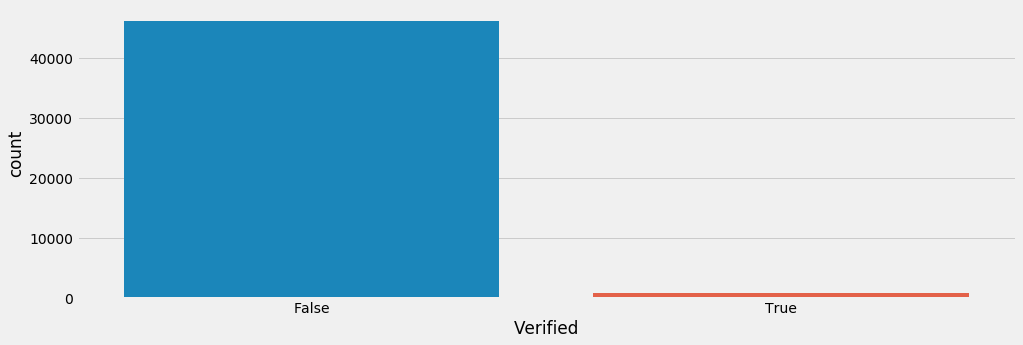

In [139]:
bar = sns.countplot(df['Verified'])

In [140]:
df['Verified'].value_counts()

False    46230
True       862
Name: Verified, dtype: int64

Only 216 verified accounts were extracted. This shouldn't be a problem while calculating our sentiment.

In [141]:
df_verified = df.query('Verified == True')
df_verified 

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet
8,2020-07-21 23:58:25,1285725851884179468,True,#Trump supporter pees on the floor rather than...,tomleykis,"Santa Barbara Cty, California",Twitter for Android,7,21339,487,2,trump supporter pees on the floor rather than ...
45,2020-07-21 23:55:03,1285725006643826690,True,Well that didn't take long.\nPress conference ...,Cairo67Unedited,United States,Twitter for Android,3,51058,672,4,well that didn t take long press conference wh...
49,2020-07-21 23:54:03,1285724753404334080,True,It took a World War to get rid of #Hitler... ...,DeeTwoCents,"Brooklyn, NY",Twitter for iPhone,115,42995,1582,21,it took a world war to get rid of hitler fo...
61,2020-07-21 23:52:50,1285724447471697921,True,#Fascist #trump take over of #USA? A trial ru...,drzarni,"London, UK",Twitter for Android,1,23977,1790,0,fascist trump take over of usa a trial run at...
169,2020-07-21 23:40:24,1285721317447290882,True,"#Trump says "" virus will get worse before it g...",Cairo67Unedited,United States,Twitter for Android,0,51058,672,1,trump says virus will get worse before it ge...
...,...,...,...,...,...,...,...,...,...,...,...,...
46752,2020-07-14 13:54:25,1283037134866317316,True,Decision this year by #Trump admin. to allow t...,marywareham,"Washington, DC",Twitter Web App,27,13461,3366,18,decision this year by trump admin to allow th...
46817,2020-07-14 13:45:22,1283034856302284803,True,United States didn't negotiate or sign the 200...,marywareham,"Washington, DC",Twitter Web App,2,13461,3366,2,united states didn t negotiate or sign the tre...
46919,2020-07-14 13:28:23,1283030585229881353,True,"#OPINION: Like #Trump, #Biden wants to end the...",arabnews,Saudi Arabia,Twitter Web App,4,285238,38,2,opinion like trump biden wants to end the us...
46961,2020-07-14 13:20:30,1283028601533861890,True,🗣🗣🗣THAT’S MY MAYOR!!!! THE #MAN!!!!! #MAYOR ...,DeQuinaMoore,"Houston, ATL, NY, & LA",Instagram,2,8759,1239,0,thats my mayor the man mayor sylveste...


In [142]:
df_verified['User'].value_counts()

Cairo67Unedited    43
AndyOstroy         38
alana_austin       27
DeeTwoCents        24
Rasmussen_Poll     21
                   ..
DebraMessing        1
IndiaToday          1
NEWS9TWEETS         1
theanthonyhayes     1
Nick_Anderson_      1
Name: User, Length: 323, dtype: int64

A user by the name AndyOstroy has 15 tweets about Joe Biden in the time-period of extraction. Let us look at some of his tweets.

In [143]:
df_verified.query('User == "AndyOstroy"').Processed_Tweet.tolist()

['to everyone wanking off right now to trump s big  pivot  today of  embracing  masks and distancing   please don t make me rub it in your face tomorrow when he returns to being a mask mocking sociopath    covid   coronavirus',
 'republicans  definition of trump derangement syndrome january   he s living rent free in libtards  heads  now   good lord   he s gonna cost us the white house and the senate    ',
 'this might be a tad psychological  but if we re ever to truly understand trump s deranged pathology we ll need to understand why he wishes unconscionably corrupt evil people like ghislainemaxwell  well    ',
 'so  in stunningly meaningless minutes from we learn that covid   s gonna get worse before it gets better    and that he carries a mask in his pocket  do coronavirus droplets spread through cheap  s suits  trump',
 ' trump just said twice about global child sex trafficker ghislainemaxwell   i wish her well    ',
 'wrote this years ago  not such a stretch now  is it     trump c

He seems to be very angry towards Joe Biden & clearly has no positive sentiment 

Let us look at another, JudicialWatch

In [144]:
df_verified.query('User == "JudicialWatch"').Processed_Tweet.tolist()

[]

On manual inspection, there seems to be sentiment towards Joe Biden. Can be classified as a Neutral user.

Let us observe the dates & how they fair out. Let us observe how many tweets were extracted on which date

In [145]:
days = df['Date'].dt.day.tolist()

In [146]:
no_of_days = Counter(days)
no_of_days

Counter({21: 10145, 20: 5509, 18: 7850, 17: 7564, 15: 10238, 14: 5786})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Day')

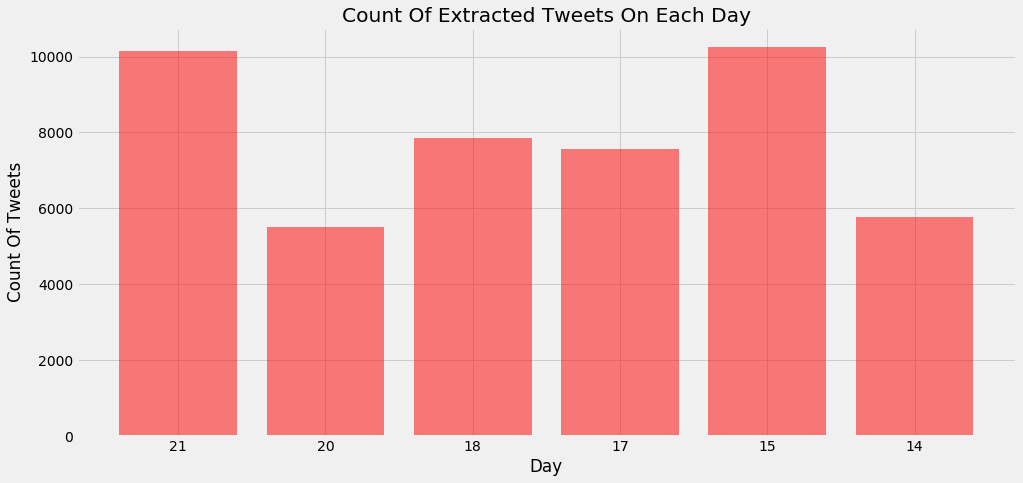

In [147]:
fig = plt.figure(figsize = (15,7))
plt.bar(range(len(no_of_days)), list(no_of_days.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_days)), list(no_of_days.keys()))
plt.xlabel("Day")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Day")

We had a maximum of approx 2000 tweets extracted on the 21st July & the 15th of July.

Let us also look at the times (hours) at which the most tweets were extracted.

In [148]:
hours = df['Date'].dt.hour.tolist()

In [149]:
no_of_hours = Counter(hours)
no_of_hours

Counter({23: 2859,
         22: 3587,
         21: 3937,
         20: 2952,
         19: 2727,
         18: 2684,
         17: 2860,
         16: 2799,
         15: 2785,
         14: 2943,
         13: 2477,
         12: 1636,
         11: 1238,
         10: 831,
         9: 706,
         8: 630,
         7: 695,
         6: 816,
         5: 936,
         4: 1090,
         3: 1456,
         2: 1578,
         1: 1485,
         0: 1385})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Hour')

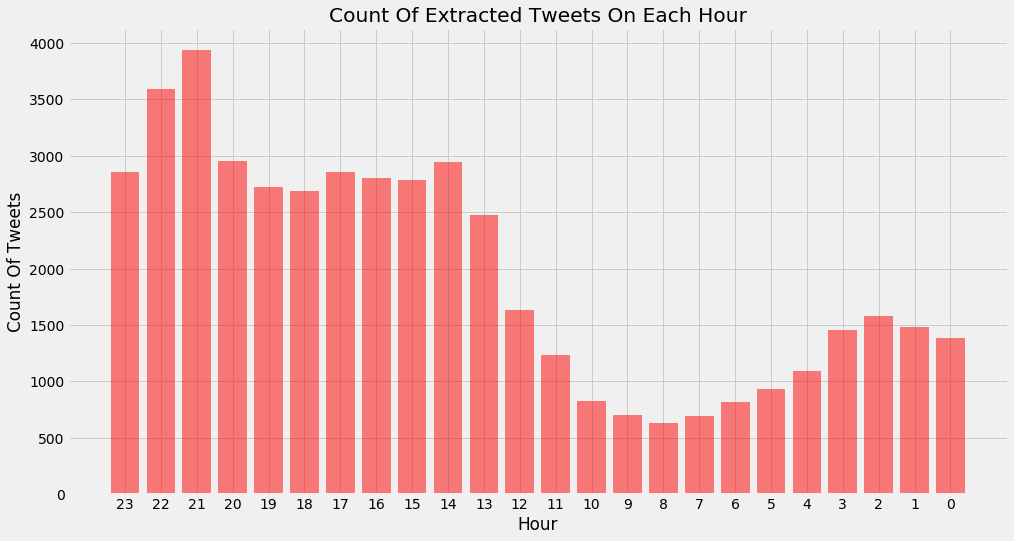

In [150]:
fig = plt.figure(figsize = (15,8))
plt.bar(range(len(no_of_hours)), list(no_of_hours.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_hours)), list(no_of_hours.keys()))
plt.xlabel("Hour")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Hour")

Lots of tweets at the 18:00 - 19:00 hour period followed by 16:00 - 17:00 hour

In [151]:
from wordcloud import WordCloud
tokenizer = TweetTokenizer()


We still have to remove stopwords, perform lemmatization & do stemming. So let us proceed with that

### Removing Stop Words

In [152]:
stop_words = set(stopwords.words('english')) 
stop_words = list(stop_words)
print(stop_words)

['up', 'for', 'during', 'just', 've', 'hadn', 'most', 'is', 'had', 'with', 'ma', 'any', 'from', "aren't", 'shan', 'that', 'between', 'or', 'those', 'does', 'weren', 'he', 'me', "should've", 'd', 'on', 'm', "won't", 'ourselves', 'about', "shouldn't", 'because', 'your', 'what', 'yourself', 'they', "mustn't", 'isn', "that'll", "it's", 'shouldn', "needn't", "shan't", "mightn't", 'to', 'been', 'hers', "didn't", 'will', 'hasn', "hasn't", "doesn't", 'didn', 'further', 'while', 'why', 'no', 'can', 'themselves', 'there', 'are', 'my', 'we', 'who', 'won', 'but', 'out', 'own', 'be', 'than', "isn't", 'her', 'doing', 'were', 'both', 'them', 'so', 'above', 'more', 'these', 'himself', 'has', 'his', 'at', 'off', "hadn't", 'ours', 'too', 'into', 'below', 'and', 'all', 'such', 'only', 'by', 'again', 'being', 'until', 'against', 'each', 'after', 'aren', 't', 'was', 's', 'needn', 'where', 'very', 'a', 'wasn', 'our', 'how', 'yours', 'whom', 'an', 'i', 'over', "couldn't", 'herself', 'haven', 'down', 'its', '

In [153]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: ' '.join(w for w in x.split() if w not in stop_words))   #Remove stopwords

In [154]:
df['Processed_Tweet']

0        amazing hope get support need resist trump ill...
1        trump finally admitted spread coronavirus get ...
2        sure sign gop party breaking apart start turni...
3        trump silent cops beat veteran put hospital bl...
4        speaking falling please careful climbing chair...
                               ...                        
47088    looks like borisjohnson pandering trump ready ...
47089    us map must look like november rd like agree v...
47090    death count countries took prompt aggressive a...
47091    human one possess empathy moral daniel lewis l...
47092    douglas london former cia senior operations of...
Name: Processed_Tweet, Length: 47092, dtype: object

## Tokenizing

In [155]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: tokenizer.tokenize(x))

In [156]:
df['Processed_Tweet']

0        [amazing, hope, get, support, need, resist, tr...
1        [trump, finally, admitted, spread, coronavirus...
2        [sure, sign, gop, party, breaking, apart, star...
3        [trump, silent, cops, beat, veteran, put, hosp...
4        [speaking, falling, please, careful, climbing,...
                               ...                        
47088    [looks, like, borisjohnson, pandering, trump, ...
47089    [us, map, must, look, like, november, rd, like...
47090    [death, count, countries, took, prompt, aggres...
47091    [human, one, possess, empathy, moral, daniel, ...
47092    [douglas, london, former, cia, senior, operati...
Name: Processed_Tweet, Length: 47092, dtype: object

## Stemming & Lemmatization

In [157]:
#Perform stemming & lemmatization
def lemmatize_stemming(text):
    stemmer=PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [158]:
df['Processed_Tweet'] = df['Processed_Tweet'].apply(lambda x: [lemmatize_stemming(i) for i in x]) # stemming

In [159]:
df['Processed_Tweet']

0        [amaz, hope, get, support, need, resist, trump...
1        [trump, final, admit, spread, coronaviru, get,...
2        [sure, sign, gop, parti, break, apart, start, ...
3        [trump, silent, cop, beat, veteran, put, hospi...
4        [speak, fall, pleas, care, climb, chairthos, p...
                               ...                        
47088    [look, like, borisjohnson, pander, trump, read...
47089    [us, map, must, look, like, novemb, rd, like, ...
47090    [death, count, countri, take, prompt, aggress,...
47091    [human, one, possess, empathi, moral, daniel, ...
47092    [dougla, london, former, cia, senior, oper, of...
Name: Processed_Tweet, Length: 47092, dtype: object

In [160]:
df['Processed_Tweet'] = df.Processed_Tweet.apply(lambda x: [i for i in x if len(i)>2])

In [161]:
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump..."
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,NaN,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,..."
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ..."
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi..."
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p..."
...,...,...,...,...,...,...,...,...,...,...,...,...
47088,2020-07-14 13:00:29,1283023564157923330,False,Looks like #BorisJohnson is pandering to #Trum...,BananaaAlana,"Salford, England",Twitter for iPhone,0,804,1447,0,"[look, like, borisjohnson, pander, trump, read..."
47089,2020-07-14 13:00:28,1283023556855705600,False,This is what the US map MUST look like on NOVE...,Deleno12,America 🇺🇸🇺🇸,Hypefury,4,493,226,3,"[map, must, look, like, novemb, like, agre, vo..."
47090,2020-07-14 13:00:24,1283023541496156162,False,@thehill Death-count 7/14 in countries that to...,tomfervoy,"New York, NY",Twitter for iPhone,10,442,1085,7,"[death, count, countri, take, prompt, aggress,..."
47091,2020-07-14 13:00:20,1283023527164227584,False,"To be human, one has to possess empathy and mo...",CFaurholt,"San Diego, CA",Twitter Web App,0,125,774,0,"[human, one, possess, empathi, moral, daniel, ..."


Creating strings for each tweet for putting in the model

In [162]:
texts = []
texts = df.Processed_Tweet.apply(lambda x: [i for i in x] )

In [163]:
all_words = []
for i in texts:
    all_words.append(" ".join(i))
    
all_words

['amaz hope get support need resist trump illeg goon squad tuesdaymotiv tuesdaythought',
 'trump final admit spread coronaviru get wors get better late join parti snack suppos month ago unfittobepresid coronaviru',
 'sure sign gop parti break apart start turn lapdoglindsey right say trump would destroy would deserv ripgop',
 'trump silent cop beat veteran put hospit black guy kneel protest tweet hundr time good question cult',
 'speak fall pleas care climb chairthos phone book your sit tricki troll liter maga trump liberalismisamentaldisord trump',
 'tonight suprem leader trump say would get wors get better feb say case would zero soon want everyon wear mask wow american death onboard dementia',
 'realli speshul forc soldier trump push admiss scientif fact make insan conspiraci theori qanon jack baeuer tortur chicom agent right ungratefultrusttheplan wwg wga',
 'piss child sex traffick trumpisgarbag trump cozi child sex traffick still unconcern assassin american soldier',
 'trump suppo

In [164]:
text = []
for i in texts:
    for j in i:
        text.append(j)

In [165]:
len(text)

704719

In [166]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(text))

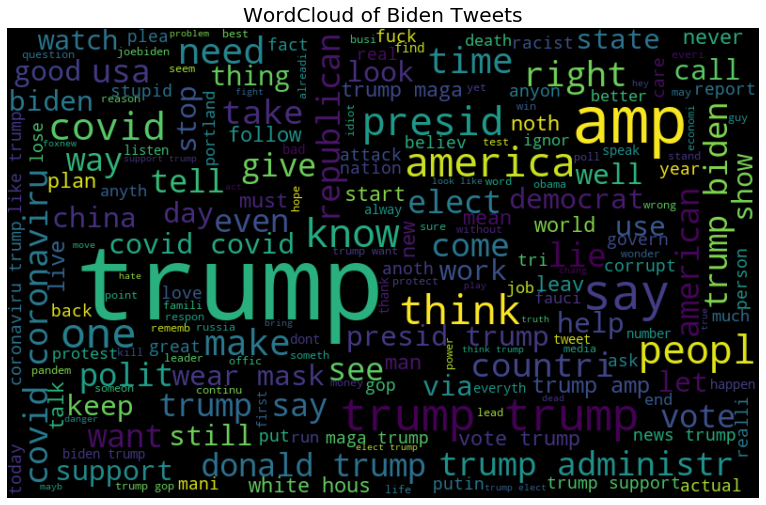

In [167]:
plt.figure(figsize = (12, 12), facecolor="None") 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.title("WordCloud of Biden Tweets")
plt.show()

## Sentiment Analysis

In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Defining the vectorizer 
vect = TfidfVectorizer(ngram_range=(1,1), max_features=100).fit(text)

# Transform the vectorizer
X_txt = vect.transform(text)

# Transforming to a data frame 
X=pd.DataFrame(X_txt.toarray(), columns=vect.get_feature_names())
X.head(10)

,administr,america,american,amp,back,believ,biden,break,call,campaign,...,want,watch,way,wear,well,white,work,world,would,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [169]:
from textblob import TextBlob

In [170]:
pol=[]
for Tweet in all_words:
    blob = TextBlob(Tweet)
    pol.append(blob.sentiment.polarity)

In [171]:
len(pol)

47092

In [172]:
len(text)

704719

In [173]:
df['Processed_Tweet']

0        [amaz, hope, get, support, need, resist, trump...
1        [trump, final, admit, spread, coronaviru, get,...
2        [sure, sign, gop, parti, break, apart, start, ...
3        [trump, silent, cop, beat, veteran, put, hospi...
4        [speak, fall, pleas, care, climb, chairthos, p...
                               ...                        
47088    [look, like, borisjohnson, pander, trump, read...
47089    [map, must, look, like, novemb, like, agre, vo...
47090    [death, count, countri, take, prompt, aggress,...
47091    [human, one, possess, empathi, moral, daniel, ...
47092    [dougla, london, former, cia, senior, oper, of...
Name: Processed_Tweet, Length: 47092, dtype: object

Classifying tweets as neutral, positive, negative

In [174]:
positive=0
negative=0
neutral=0
for i in pol:
    if i>0:
        positive+=1
    elif i<0:
        negative+=1
    else:
        neutral+=1
print("Positive Tweets:",positive)
print("Negative Tweets:",negative)
print("Neutral Tweets",neutral)

Positive Tweets: 15952
Negative Tweets: 11189
Neutral Tweets 19951


In [175]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ROSHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [176]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sentiment_scores= []
for i in all_words:
    sentiment_scores.append([sid.polarity_scores(i)])
#sentimental_score = pd.DataFrame(list(sentiment_scores))
#sentimental_score.tail(12)


In [177]:
value = []
for i in sentiment_scores:
    for dict1 in i:
        value.append(list(dict1.values()))

value

[[0.0, 0.641, 0.359, 0.6808],
 [0.0, 0.685, 0.315, 0.7096],
 [0.168, 0.721, 0.111, -0.296],
 [0.101, 0.754, 0.146, 0.2263],
 [0.0, 0.833, 0.167, 0.4939],
 [0.119, 0.638, 0.243, 0.4767],
 [0.0, 1.0, 0.0, 0.0],
 [0.162, 0.838, 0.0, -0.4019],
 [0.0, 0.748, 0.252, 0.4019],
 [0.0, 0.566, 0.434, 0.3182],
 [0.0, 0.894, 0.106, 0.2235],
 [0.191, 0.809, 0.0, -0.3818],
 [0.136, 0.442, 0.422, 0.8928],
 [0.0, 1.0, 0.0, 0.0],
 [0.396, 0.478, 0.126, -0.7351],
 [0.0, 0.854, 0.146, 0.4404],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.063, 0.448, 0.49, 0.9062],
 [0.0, 1.0, 0.0, 0.0],
 [0.134, 0.866, 0.0, -0.5267],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.734, 0.266, 0.7096],
 [0.092, 0.655, 0.253, 0.5719],
 [0.0, 0.599, 0.401, 0.9081],
 [0.0, 1.0, 0.0, 0.0],
 [0.0, 0.625, 0.375, 0.6369],
 [0.149, 0.851, 0.0, -0.5994],
 [0.173, 0.827, 0.0, -0.5859],
 [0.123, 0.736, 0.141, -0.1027],
 [0.636, 0.364, 0.0, -0.5423],
 [0.

In [178]:
sentimental_score_df = pd.DataFrame(data = value, columns = ['Negative','Neutral','Positive','Compound'])
sentimental_score_df

,Negative,Neutral,Positive,Compound
0,0.000,0.641,0.359,0.6808
1,0.000,0.685,0.315,0.7096
2,0.168,0.721,0.111,-0.2960
3,0.101,0.754,0.146,0.2263
4,0.000,0.833,0.167,0.4939
...,...,...,...,...
47087,0.000,0.828,0.172,0.3612
47088,0.000,0.706,0.294,0.6124
47089,0.363,0.537,0.100,-0.8957
47090,0.000,1.000,0.000,0.0000


In [179]:
sentimental_score_df['val'] = sentimental_score_df['Compound'].apply(lambda x: 'Neutral' if x == 0 else ('Positive' if x > 0 else 'Negative'))
sentimental_score_df.head()

,Negative,Neutral,Positive,Compound,val
0,0.000,0.641,0.359,0.6808,Positive
1,0.000,0.685,0.315,0.7096,Positive
2,0.168,0.721,0.111,-0.2960,Negative
3,0.101,0.754,0.146,0.2263,Positive
4,0.000,0.833,0.167,0.4939,Positive


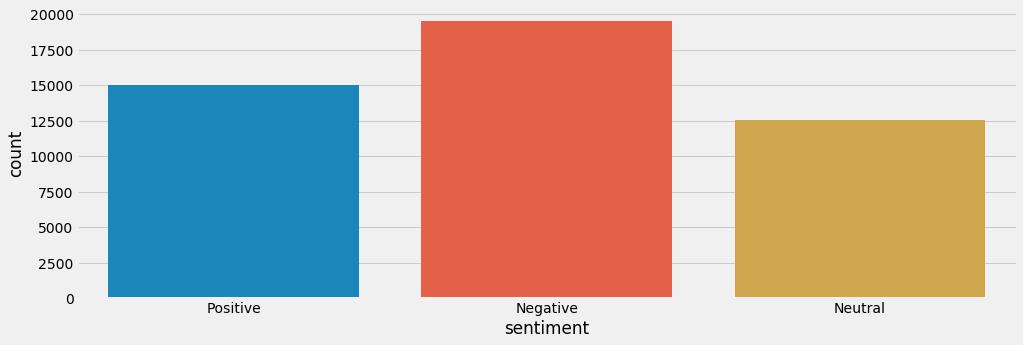

In [180]:
sent_count = pd.DataFrame.from_dict(Counter(sentimental_score_df['val']), orient = 'index').reset_index()
sent_count.columns = ['sentiment', 'count']

sns.barplot(y="count", x='sentiment', data=sent_count)

In [181]:
filepath = r"C:\Users\ROSHAN\Documents\GitHub\extracting-tweets-forecasting-the-upcoming-elections-in-the-us\NRC Emotion Lexicon.txt"
emolex_df = pd.read_csv(filepath,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
emolex_df.head(12)
len(emolex_df)

86343

In [182]:
emotions={'positive':0, 'negative':0, 'surprise':0,'sadness':0,
          'anger':0,'joy':0,'negative':0,'trust':0,'fear':0,'anticipation':0,'disgust':0}

In [183]:
word_emotion=dict()
for i in range(0,86343):
    emotion=emolex_df['emotion'][i]
    word=emolex_df['word'][i]
    association=emolex_df['association'][i]
    
    if word not in word_emotion:
        word_emotion[word]=dict()
    word_emotion[word][emotion]=association
    

In [184]:
word_emotion

{'abandonment': {'joy': 0.0,
  'negative': 1.0,
  'positive': 0.0,
  'sadness': 1.0,
  'surprise': 1.0,
  'trust': 0.0},
 'abate': {'anger': 0.0,
  'anticipation': 0.0,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.0,
  'negative': 0.0,
  'positive': 0.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 0.0},
 'abatement': {'anger': 0.0,
  'anticipation': 0.0,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.0,
  'negative': 0.0,
  'positive': 0.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 0.0},
 'abba': {'anger': 0.0,
  'anticipation': 0.0,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.0,
  'negative': 0.0,
  'positive': 1.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 0.0},
 'abbot': {'anger': 0.0,
  'anticipation': 0.0,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.0,
  'negative': 0.0,
  'positive': 0.0,
  'sadness': 0.0,
  'surprise': 0.0,
  'trust': 1.0},
 'abbreviate': {'anger': 0.0,
  'anticipation': 0.0,
  'disgust': 0.0,
  'fear': 0.0,
  'joy': 0.0,
  'negative': 0.0,
  'positi

In [185]:
for i in range(0,15046):
    text=df['Tweet'][i]
    for j in text.split():
        if j in word_emotion:
            for k in word_emotion[j]:
                emotions[k]+=word_emotion[j][k]

In [186]:
emotions

{'positive': 5731.0,
 'negative': 6918.0,
 'surprise': 1718.0,
 'sadness': 3171.0,
 'anger': 3698.0,
 'joy': 2080.0,
 'trust': 3665.0,
 'fear': 4094.0,
 'anticipation': 2467.0,
 'disgust': 2432.0}

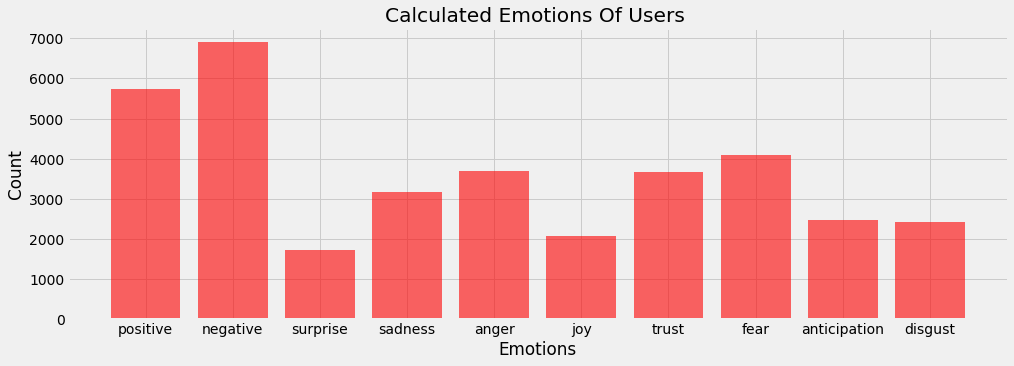

In [187]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [15,5]
plt.bar(list(emotions.keys()),list(emotions.values()),color='red',alpha = 0.6)
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Calculated Emotions Of Users ')
plt.show()

In [188]:
df.Location  = df.Location.fillna('USA')

In [189]:
f = [i for i in df['Location'] if type(i) != str]
f

[]

In [190]:
df.Location = df.Location.apply(lambda x: x.replace('United States','USA'))

In [191]:
df.Location.value_counts()

USA                               15357
California, USA                     877
Washington, DC                      633
Los Angeles, CA                     385
New York, NY                        305
                                  ...  
Winnipeg Manitoba Canada,             1
CHICAGO 2 LA                          1
Beautiful/Fragile Planet Earth        1
The Milky Way                         1
Mymensingh                            1
Name: Location, Length: 6613, dtype: int64

In [192]:
locations = []
locations_1 = []

locations = [i.split(',')[-1] for i in df['Location']]
locations_1 =  [i.split(',')[0] for i in df['Location']]
df['Processed_Location'] = locations_1
df

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump...",Patterson
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,USA,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,...",USA
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ...",Texas
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi...",NJ-DC-NY-🌍
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p...",• GOD BLESS AMERICA •
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47088,2020-07-14 13:00:29,1283023564157923330,False,Looks like #BorisJohnson is pandering to #Trum...,BananaaAlana,"Salford, England",Twitter for iPhone,0,804,1447,0,"[look, like, borisjohnson, pander, trump, read...",Salford
47089,2020-07-14 13:00:28,1283023556855705600,False,This is what the US map MUST look like on NOVE...,Deleno12,America 🇺🇸🇺🇸,Hypefury,4,493,226,3,"[map, must, look, like, novemb, like, agre, vo...",America 🇺🇸🇺🇸
47090,2020-07-14 13:00:24,1283023541496156162,False,@thehill Death-count 7/14 in countries that to...,tomfervoy,"New York, NY",Twitter for iPhone,10,442,1085,7,"[death, count, countri, take, prompt, aggress,...",New York
47091,2020-07-14 13:00:20,1283023527164227584,False,"To be human, one has to possess empathy and mo...",CFaurholt,"San Diego, CA",Twitter Web App,0,125,774,0,"[human, one, possess, empathi, moral, daniel, ...",San Diego


In [193]:
df1 = df

In [194]:
df1['sentiment'] = sentimental_score_df['val']

In [195]:
df1.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump...",Patterson,Positive
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,USA,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,...",USA,Positive
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ...",Texas,Negative
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi...",NJ-DC-NY-🌍,Positive
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p...",• GOD BLESS AMERICA •,Positive


In [196]:
#df1.to_csv('Location.csv',index = False)

In [197]:
#df1.to_csv('Location1.csv',index = False)

In [198]:
df1['day'] = df.Date.dt.day
df1.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets,Processed_Tweet,Processed_Location,sentiment,day
0,2020-07-21 23:59:54,1285726226813014016,False,"You are amazing, @chicagosmayor. I hope you g...",rathacat,"Patterson, CA",Twitter Web App,1,2429,3710,0,"[amaz, hope, get, support, need, resist, trump...",Patterson,Positive,21
1,2020-07-21 23:59:51,1285726213001093127,False,#Trump finally admitted that the spread of the...,Nor_Kan_1965,USA,Twitter for Android,1,112,73,1,"[trump, final, admit, spread, coronaviru, get,...",USA,Positive,21
2,2020-07-21 23:59:30,1285726126820794368,False,@NavygirlLaura @GOP A sure sign the #GOP party...,ShannsolSolberg,"Texas, USA",Twitter for iPhone,1,1359,1745,0,"[sure, sign, gop, parti, break, apart, start, ...",Texas,Negative,21
3,2020-07-21 23:59:20,1285726083455877121,False,Why is #Trump silent when cops beat a #Veteran...,in_pubs,NJ-DC-NY-🌍,Twitter for iPhone,650,78851,17726,254,"[trump, silent, cop, beat, veteran, put, hospi...",NJ-DC-NY-🌍,Positive,21
4,2020-07-21 23:58:51,1285725963024818183,False,"@gtconway3d Speaking of falling, please be car...",dfwcitizen,• GOD BLESS AMERICA •,Twitter for iPhone,2,5333,375,0,"[speak, fall, pleas, care, climb, chairthos, p...",• GOD BLESS AMERICA •,Positive,21


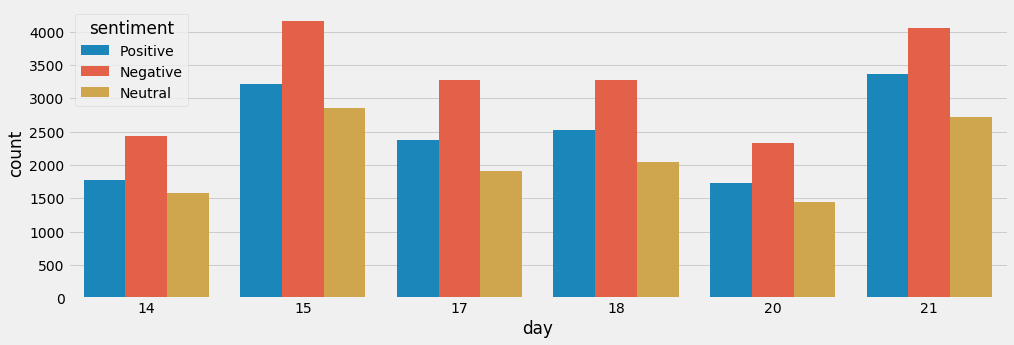

In [199]:
sns.countplot(df['day'],hue = df['sentiment'])

In [200]:
df1.to_excel("output_trump.xlsx") 

C:\Users\ROSHAN\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:931: UserWarning: Ignoring URL 'https://t.co/PvjmY4IHpt%20The%20' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
C:\Users\ROSHAN\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:931: UserWarning: Ignoring URL 'https://t.co/9cPVGy4EQC

Can't%20wait%20for%20an%20idiot%20' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
C:\Users\ROSHAN\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:931: UserWarning: Ignoring URL 'https://t.co/s1WVee94Ue%20' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
C:\Users\ROSHAN\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:931: UserWarning: Ignoring URL 'https://t.co/B2l0eVHjKA%20My%20latest%20' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
C:\

C:\Users\ROSHAN\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:931: UserWarning: Ignoring URL 'https://t.co/nEUyJc1nte%20%20
Trump%20hides%20high%20school,%20college%20records,%20taxes
Congress%20Pressure%20as%20Trump%20Administration%20Evades%20Bailout%20Oversight
%20independent%20watchdogs%20sound%20an%20oversight%20alarm,%20People%20demand%20to%20know%20who%20got%20$500%20billion%20in%20small-business%20loans.%20
' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
C:\Users\ROSHAN\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:931: UserWarning: Ignoring URL 'https://t.co/wjp1IZhqzI%20
👆
listing%20is%20in%20link%20

' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
